In [186]:
#Agregamos las librerías necesarias
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [187]:
#Cargamos los datos y vemos los primeros registros
data = pd.read_csv('data/properatti.csv')
data.head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.00,"-34.6618237,-58.5088387",-34.66,...,40.00,1127.27,1550.00,nan,nan,nan,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.00,"-34.9038831,-57.9643295",-34.90,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.00,"-34.6522615,-58.5229825",-34.65,...,55.00,1309.09,1309.09,nan,nan,nan,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.00,"-34.6477969,-58.5164244",-34.65,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.00,"-38.0026256,-57.5494468",-38.00,...,35.00,1828.57,1828.57,nan,nan,nan,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


In [188]:
''' Vemos las columnas '''

data.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

In [189]:
data.shape

(121220, 26)

<AxesSubplot:title={'center':'Nulos por columna'}, ylabel='Columna'>

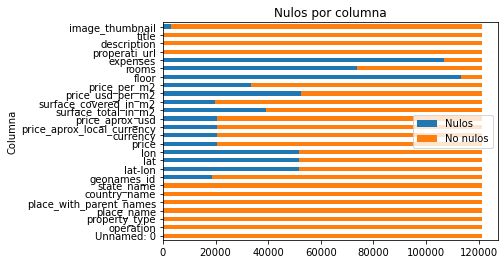

In [190]:
nulls = pd.DataFrame({'Columna':data.columns, 'Nulos':data.isnull().sum(),'No nulos':data.notnull().sum()})

# plot a Stacked Bar Chart using matplotlib
nulls.plot(
  x = 'Columna', 
  kind = 'barh', 
  stacked = True, 
  title = 'Nulos por columna', 
  mark_right = True)

---
Eliminamos las columnas que no aportan informacion, como operation es sell la quitamos, expensas también no aporta información y es un dato que nunca se completa correctamente, country son todos de argentina no aporta nada. Image_thumbnail no aporta información ni la dirección url

In [191]:
data = data.drop(['Unnamed: 0','operation','country_name','expenses','image_thumbnail', 'properati_url'], axis=1)

---
## Relleno de nulls
### Place names

In [192]:
print("Place names null antes: ", data.place_name.isnull().sum())

''' completar los places names '''
data.loc[data.place_name.isnull(),'place_name'] = data.loc[data.place_name.isnull()].place_with_parent_names.str.split('|', expand=True)[3]

#Relleno manualmente un dato que está suelto
mask=(data.place_name=='coordenadas 34.255511')
data.loc[mask,'place_name'] = 'Rincón de Milberg'

'''place names nulls despues de completar'''

print("Place names null después: ", data.place_name.isnull().sum())

Place names null antes:  23
Place names null después:  0


### Currency

In [193]:
''' revisamos en que moneda se encuentran expresadas las propiedades'''
data.currency.value_counts()

USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

In [194]:
#Chequeo anterior
print('Price aprox usd nulls antes: ',data.price_aprox_usd.isnull().sum())

#Extraemos de las descripciones los montos en dólares para completar dólares
patron = r'(\bU\$S|usd|uss|dól|dol)(\s)*(?P<miles>\d+)(\.)?(?P<unidades>\d*)'

#Guardamos los valores y lo asignamos en la columna price_aprox_usd
p_dls = data.loc[data.price_aprox_usd.isnull()].description.str.extract(patron, flags= re.IGNORECASE, expand = False)
p_dls['miles'] = pd.to_numeric(p_dls['miles'], errors= 'coerce')
p_dls['unidades'] = pd.to_numeric(p_dls['unidades'], errors= 'coerce')
data.loc[data.price_aprox_usd.isnull(),'price_aprox_usd'] = p_dls['miles']*1000 + p_dls['unidades']

print('Price aprox usd nulls después: ',data.price_aprox_usd.isnull().sum())

Price aprox usd nulls antes:  20410
Price aprox usd nulls después:  19854


In [195]:
#Extraemos de los títulos los montos en dólares para completar dólares
p_dls = data.loc[data.price_aprox_usd.isnull()].title.str.extract(patron, flags= re.IGNORECASE, expand = False)
p_dls['miles'] = pd.to_numeric(p_dls['miles'], errors= 'coerce')
p_dls['unidades'] = pd.to_numeric(p_dls['unidades'], errors= 'coerce')
data.loc[data.price_aprox_usd.isnull(),'price_aprox_usd'] = p_dls['miles']*1000 + p_dls['unidades']

print('Price aprox usd nulls después: ',data.price_aprox_usd.isnull().sum())

Price aprox usd nulls después:  19849


In [196]:
''' Exploramos las columnas de los precios para ver si hay datos no nulos'''

pricenull = data.loc[data['price_aprox_usd'].isna()].loc[:,['surface_covered_in_m2','price','price_aprox_local_currency','price_usd_per_m2','price_per_m2']]

pricenull.isna().sum()

surface_covered_in_m2          6694
price                         19849
price_aprox_local_currency    19849
price_usd_per_m2              19849
price_per_m2                  19849
dtype: int64

In [197]:
''' quitar los precios nulos '''

data = data.drop(data[data['price_aprox_usd'].isna()].index)
cant_nulls = data.isnull().sum()
print(cant_nulls)
print('---')
print('Porcentaje de nulos:')
print(cant_nulls/data.shape[0]*100)

property_type                     0
place_name                        0
place_with_parent_names           0
state_name                        0
geonames_id                   17043
lat-lon                       42472
lat                           42472
lon                           42472
price                           561
currency                        562
price_aprox_local_currency      561
price_aprox_usd                   0
surface_total_in_m2           32035
surface_covered_in_m2         13213
price_usd_per_m2              32754
price_per_m2                  13713
floor                         94415
rooms                         61475
description                       2
title                             0
dtype: int64
---
Porcentaje de nulos:
property_type                 0.00
place_name                    0.00
place_with_parent_names       0.00
state_name                    0.00
geonames_id                  16.81
lat-lon                      41.90
lat                          41.

### Rooms

In [198]:
#Antes
print('Nulos antes: ',data.rooms.isnull().sum())

#Relleno con patron regex según la palabra ambiente
patron = '((?P<numero>\d|mono|dos|tres|cuatro|cinco|seis)\s*(?P<ambiente>amb))'
patron_regex = re.compile(patron,flags = re.IGNORECASE)

def convertRoomFromAmbiente(row):  
    try:
        resultado=None
        ambientes=0
        if (row['description'] and isinstance(row['description'],str)):
            resultado = patron_regex.search(row['description'])
        if ((resultado is None) and row['title'] and isinstance(row['title'],str)):
            resultado = patron_regex.search(row['title'])
        if (resultado is not None):
            if (resultado.group('numero2').lower()=='un'):
                ambientes+=1
            elif(resultado.group('numero2').lower()=='dos'):
                ambientes+=2
            elif(resultado.group('numero2').lower()=='tres'):
                ambientes+=3
            elif(resultado.group('numero2').lower()=='cuatro'):
                ambientes+=4
            elif(resultado.group('numero2').lower()=='cinco'):
                ambientes+=5
            elif(resultado.group('numero2').lower()=='seis'):
                ambientes+=6
            else:
                ambientes=int(resultado.group('numero'))
        return ambientes
    except:
        return np.nan
        
data.loc[data.rooms.isnull(),'rooms'] = data.loc[data.rooms.isnull()].apply(convertRoomFromAmbiente,axis=1)

#Relleno con patron regex según la palabra dormitorio o habitación
patron = '"((?P<numero>\d|un|dos|tres|cuatro|cinco|seis)(\s\w+)?\s(?P<dormitorios>dorm|hab|HAB|Hab))"'
patron_dormhab = re.compile(patron,flags = re.IGNORECASE)

def convertRoomFromDormHab(row):
    resultado = None
    if (row['description'] and isinstance(row['description'],str)):
        resultado = patron_dormhab.finditer(row['description'])
    if ((resultado is None) and row['title'] and isinstance(row['title'],str)):
        resultado = patron_dormhab.finditer(row['description'])
    if not(resultado is None):
        dormitorios=0
        for m in resultado:
            if m.group('numero') is None:
                dormitorios=np.nan
            else:
                if(m.group('numero').lower()=='un'):
                    dormitorios+=1
                elif(m.group('numero').lower()=='dos'):
                    dormitorios+=2
                elif(m.group('numero').lower()=='tres'):
                    dormitorios+=3
                elif(m.group('numero').lower()=='cuatro'):
                    dormitorios+=4
                elif(m.group('numero').lower()=='cinco'):
                    dormitorios+=5
                elif(m.group('numero').lower()=='seis'):
                    dormitorios+=6
                else:
                    dormitorios+=int(m.group('numero'))
    if not(np.isnan(dormitorios)) and dormitorios>0:
        return dormitorios
    else:
        return np.nan

data.loc[data.rooms.isnull(),'rooms'] = data.loc[data.rooms.isnull()].apply(convertRoomFromDormHab,axis=1)

''' rooms despues de limpiar'''
print('Nulos después: ',data.rooms.isnull().sum())

Nulos antes:  61475
Nulos después:  25490


### Superficie

In [199]:
#Completamos ambas columnas de superficie

data.loc[data.surface_covered_in_m2 > data.surface_total_in_m2,'surface_total_in_m2'] = data.loc[data.surface_covered_in_m2 > data.surface_total_in_m2,'surface_covered_in_m2']

data['surface_covered_in_m2'] = data['surface_covered_in_m2'].fillna(data['surface_total_in_m2'])
data['surface_total_in_m2'] = data['surface_total_in_m2'].fillna(data['surface_covered_in_m2'])

data.loc[data.surface_total_in_m2 < 10,'surface_total_in_m2'] = np.NaN

print(data['surface_covered_in_m2'].isnull().value_counts())

print(data['surface_total_in_m2'].isnull().value_counts()) 

False    93682
True      7689
Name: surface_covered_in_m2, dtype: int64
False    93194
True      8177
Name: surface_total_in_m2, dtype: int64


### Metros cuadrados

In [200]:
print('Nulls antes: ',data.surface_total_in_m2.isnull().sum())

patron_meters = re.compile("(?P<Metros>\d+)(?P<tipo>metro|\smetro|mts|\smts|m2|\sm2)",flags = re.IGNORECASE)

def extractMeters(row):
    meters_match = None
    if ( row['description'] and isinstance(row['description'],str) ):
        meters_match = patron_meters.search(row['description'])
    if ((meters_match is None) and row['title'] and isinstance(row['title'],str)):
        meters_match = patron_meters.search(row['title'])
    if (meters_match is not None):
        return meters_match.groups()[0]
    return None

data.loc[data.surface_total_in_m2.isnull(),'surface_total_in_m2'] = data.loc[data.surface_total_in_m2.isnull()].apply(extractMeters,axis=1)

data.loc[data.surface_total_in_m2.isnull() & data.surface_covered_in_m2.notnull(),'surface_total_in_m2'] = data.loc[data.surface_total_in_m2.isnull() & data.surface_covered_in_m2.notnull()].apply(lambda x: x['surface_covered_in_m2'],axis=1)

data.loc[data.surface_total_in_m2.isnull(),'surface_total_in_m2'] = data.loc[data.surface_total_in_m2.isnull()].surface_total_in_m2.fillna(value=np.nan)
data.loc[:,'surface_total_in_m2'] = data.loc[:,'surface_total_in_m2'].astype("float")

''' cuantos quedaron'''
print('Nulls después: ',data.surface_total_in_m2.isnull().sum())

Nulls antes:  8177
Nulls después:  5924


In [201]:
data.loc[data.surface_total_in_m2 < 10,'surface_total_in_m2'] = np.NaN
data.surface_total_in_m2.isnull().sum()

6456

In [202]:
#Completamos la columna price usd per m2 para los valores que rellenamos
data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.isnull() & data.surface_total_in_m2 > 0,'price_usd_per_m2'] = data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.isnull() & data.surface_total_in_m2 > 0].apply(lambda x: x['price_aprox_usd'] / x['surface_total_in_m2'],axis=1)

cant_nulls = data.isnull().sum()
print(cant_nulls)

property_type                     0
place_name                        0
place_with_parent_names           0
state_name                        0
geonames_id                   17043
lat-lon                       42472
lat                           42472
lon                           42472
price                           561
currency                        562
price_aprox_local_currency      561
price_aprox_usd                   0
surface_total_in_m2            6456
surface_covered_in_m2          7689
price_usd_per_m2               6456
price_per_m2                  13713
floor                         94415
rooms                         25490
description                       2
title                             0
dtype: int64


### Piso
Para los departamentos

In [203]:
''' cuantos departamentos tienen el piso en null '''
len(data.loc[(data.property_type == 'apartment') & (data.floor.isnull())].index)

54024

In [204]:
patron_floor = re.compile("(?P<piso0>planta baja|PB)|(?P<piso1>1er piso|primer piso|piso 1|1º piso|piso 1º)|(?P<piso2>2do piso|segundo piso|piso 2|2º piso|piso 2º)|(?P<piso3>3er piso|tercer piso|piso 3|3º piso|piso 3º)|(?P<piso4>4to piso|cuarto piso|piso 4|4º piso|piso 4º)|(?P<piso5>5to piso|quinto piso|piso 5|5º piso|piso 5º)|(?P<piso6>6to piso|sexto piso|piso 6|6º piso|piso 6º)|(?P<piso7>7to piso|séptimo piso|piso 7|7º piso|piso 7º)|(?P<piso8>8vo piso|octavo piso|piso 8|8º piso|piso 8º)|(?P<piso9>9no piso|noveno piso|piso 9|9º piso|piso 9º)|(?P<piso10>10mo piso|décimo piso|piso 10|10º piso|piso 10º)|(?P<piso11>11vo piso|onceavo piso|piso 11|11º piso|piso 11º)|(?P<piso12>12vo piso|doceavo piso|piso 12|12º piso|piso 12º)|(?P<piso13>13vo piso|treceavo piso|piso 13|13º piso|piso 13º)|(?P<piso14>14vo piso|cartoceavo piso|piso 14|14º piso|piso 14º)|(?P<piso15>15vo piso|quinceavo piso|piso 15|15º piso|piso 15º)|(?P<piso16>16to piso|decimosexto piso|piso 16|16º piso|piso 16º)|(?P<piso17>17to piso|decimoséptimo piso|piso 17|17º piso|piso 17º)|(?P<piso18>18vo piso|decimooctavo piso|piso 18|18º piso|piso 18º)|(?P<piso19>19vo piso|decimonoveno piso|piso 19|19º piso|piso 19º)|(?P<piso20>20to piso|vigésimo piso|piso 20|20º piso|piso 20º)",flags = re.IGNORECASE)

def extractFloor(row):
    match = None
    if (row['description'] and isinstance(row['description'],str) ):
        match = patron_floor.search(row['description'])
    if (match is None) and row['title'] and isinstance(row['title'],str):
        match = patron_floor.search(row['title'])
    if match is None:
        return np.nan
    elif match.group('piso0') is not None:
        return 0.0
    elif match.group('piso1') is not None:
        return 1.0
    elif match.group('piso2') is not None:
        return 2.0
    elif match.group('piso3') is not None:
        return 3.0
    elif match.group('piso4') is not None:
        return 4.0
    elif match.group('piso5') is not None:
        return 5.0
    elif match.group('piso6') is not None:
        return 6.0
    elif match.group('piso7') is not None:
        return 7.0
    elif match.group('piso8') is not None:
        return 8.0
    elif match.group('piso9') is not None:
        return 9.0
    elif match.group('piso10') is not None:
        return 10.0
    elif match.group('piso11') is not None:
        return 11.0
    elif match.group('piso12') is not None:
        return 12.0
    elif match.group('piso13') is not None:
        return 13.0
    elif match.group('piso14') is not None:
        return 14.0
    elif match.group('piso15') is not None:
        return 15.0
    elif match.group('piso16') is not None:
        return 16.0
    elif match.group('piso17') is not None:
        return 17.0
    elif match.group('piso18') is not None:
        return 18.0
    elif match.group('piso19') is not None:
        return 19.0
    elif match.group('piso20') is not None:
        return 20.0
    else:
        return np.nan

data.loc[(data.property_type == 'apartment') & (data.floor.isnull()),'floor'] = data.loc[(data.property_type == 'apartment') & (data.floor.isnull())].apply(lambda x: extractFloor(x),axis =1)

''' cuantos departamentos tienen el piso en null '''
len(data.loc[(data.property_type == 'apartment') & (data.floor.isnull())].index)

37467

In [205]:
data.rooms.value_counts()

0.00     35985
2.00     10776
3.00     10444
4.00      6627
1.00      6516
5.00      3082
6.00      1093
7.00       582
8.00       281
10.00      166
9.00       134
11.00       51
12.00       43
13.00       23
15.00       21
14.00       14
17.00        9
20.00        6
16.00        5
25.00        4
19.00        4
22.00        3
18.00        3
30.00        3
21.00        2
24.00        1
23.00        1
32.00        1
27.00        1
Name: rooms, dtype: int64

### Columna disposición
Creamos la columna disposición del departamento obtenida a traves de las descripciones o los títulos

In [206]:
''' columna disposicion del dpto'''

patron_disposicion = re.compile("(?P<tipo>frente|lateral|contrafrente)",flags = re.IGNORECASE)

def disposicion(row):
    disposicion_match = None
    if ( row['description'] and isinstance(row['description'],str) ): 
        disposicion_match = patron_disposicion.search(row['description'])
    if ((patron_disposicion is None) and row['title'] and isinstance(row['title'],str)):
        disposicion_match = patron_disposicion.search(row['title'])
    if (disposicion_match is not None):
        return disposicion_match.groups()[0].lower()
    return None

data['disposicion'] =  data.apply(lambda x:disposicion(x),axis = 1)
data['disposicion'].value_counts()

frente          28667
contrafrente     5282
lateral          1815
Name: disposicion, dtype: int64

### Columna A Estrenar
Creamos la columna A Estrenar obtenida a través de las descripciones o los títulos

In [207]:
''' columna a estrenar '''
patron_a_estrenar = re.compile("(?P<tipo>estrenar)",flags = re.IGNORECASE)

def aestrenar(row):
    try:
        if (row['description'] and isinstance(row['description'],str) ):
            if (patron_a_estrenar.search(row['description']).group('tipo') is not None):
                return True
        if (row['title'] and isinstance(row['title'],str) ):
            if (patron_a_estrenar.search(row['title']).group('tipo') is not None):
                return True
    except:
        return False

data['aAstrenar'] = data.apply(lambda x:aestrenar(x),axis = 1);
data['aAstrenar'].value_counts()

False    92010
True      9361
Name: aAstrenar, dtype: int64

### Achicamos el dataset a Capital Federal

In [208]:
''' nos vamos a quedar con capital federal'''

data = data.loc[(data.state_name.str.lower() == 'capital federal') & (data.place_name.str.lower()!='capital federal')]
data.place_name.unique()

array(['Mataderos', 'Liniers', 'Belgrano', 'Palermo Soho', 'Palermo',
       'Flores', 'Boedo', 'Las Cañitas', 'Puerto Madero', 'Balvanera',
       'Caballito', 'Nuñez', 'San Telmo', 'Almagro', 'Colegiales',
       'Floresta', 'Barrio Norte', 'Barracas', 'Recoleta', 'Congreso',
       'Villa Crespo', 'Chacarita', 'Constitución', 'Villa Urquiza',
       'Palermo Hollywood', 'Saavedra', 'Monserrat', 'Pompeya',
       'Parque Chas', 'Paternal', 'Agronomía', 'Villa Pueyrredón',
       'Coghlan', 'Parque Centenario', 'Villa Luro', 'Villa Devoto',
       'Boca', 'Parque Avellaneda', 'San Cristobal', 'Abasto',
       'Versalles', 'Villa del Parque', 'Monte Castro', 'Retiro',
       'Parque Patricios', 'San Nicolás', 'Villa Santa Rita',
       'Palermo Chico', 'Centro / Microcentro', 'Once', 'Tribunales',
       'Parque Chacabuco', 'Velez Sarsfield', 'Catalinas',
       'Villa General Mitre', 'Palermo Viejo', 'Villa Lugano',
       'Villa Ortuzar', 'Villa Soldati', 'Villa Real', 'Villa Riachue

In [209]:
#Creo una columna para normalizar los palermo
data['place_name_normalized'] = data.place_name.apply(lambda x: "Palermo" if "Palermo" in x else x)
data.place_name.value_counts()

Belgrano           2561
Palermo            2525
Caballito          2062
Villa Urquiza      1430
Recoleta           1428
                   ... 
Velez Sarsfield      37
Agronomía            37
Villa Soldati        15
Villa Riachuelo       5
Catalinas             2
Name: place_name, Length: 61, dtype: int64

---
## Outliers

In [210]:
''' empezamos a buscar outliers'''

pd.options.display.float_format = '{:.2f}'.format

In [211]:
data_capital.loc[data_capital.price_usd_per_m2 > 10000,'price_usd_per_m2'] = np.NaN

''' quitamos los que tienen 3 desvios de la media'''
data.loc[data['price_usd_per_m2']>=(data['price_usd_per_m2'].mean() + 3*data['price_usd_per_m2'].std()),'price_usd_per_m2'] = np.NaN
data.loc[data['price_aprox_usd']>=(data['price_aprox_usd'].mean() + 3*data['price_aprox_usd'].std()),'price_aprox_usd'] = np.NaN
data.loc[data['surface_total_in_m2']>=(data['surface_total_in_m2'].mean() + 3*data['surface_total_in_m2'].std()),'surface_total_in_m2'] = np.NaN

In [212]:
data.price_usd_per_m2.describe()

count   27281.00
mean     2731.78
std      1586.97
min         2.75
25%      1967.29
50%      2444.44
75%      3021.67
max     16034.88
Name: price_usd_per_m2, dtype: float64

In [213]:
''' intentamos completar con los otros campos'''
data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.isnull() & data.surface_total_in_m2 > 0,'price_usd_per_m2'] = data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.isnull() & data.surface_total_in_m2 > 0].apply(lambda x: x['price_aprox_usd'] / x['surface_total_in_m2'],axis=1)
data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.isnull() & data.price_usd_per_m2.notnull() & data.surface_total_in_m2 > 0,'price_aprox_usd'] = data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.isnull() & data.price_usd_per_m2.notnull() & data.surface_total_in_m2 > 0].apply(lambda x: x['price_usd_per_m2'] * x['surface_total_in_m2'],axis=1)
data.loc[data.surface_total_in_m2.isnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.notnull() & data.price_usd_per_m2 > 0,'surface_total_in_m2'] = data.loc[data.surface_total_in_m2.isnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.notnull() & data.price_usd_per_m2 > 0].apply(lambda x: x['price_aprox_usd'] / x['price_usd_per_m2'],axis=1)

In [214]:
''' quitamos los registros sin info relevante'''

columnsUtils = ['surface_total_in_m2','price_aprox_usd', 'price_usd_per_m2']

data = data.dropna(axis =0 , how = 'any', subset = columnsUtils)

In [215]:
data = data.drop(data.loc[data.price_usd_per_m2 > 10000].index)

<AxesSubplot:title={'center':'Nulos por columna'}, ylabel='Columna'>

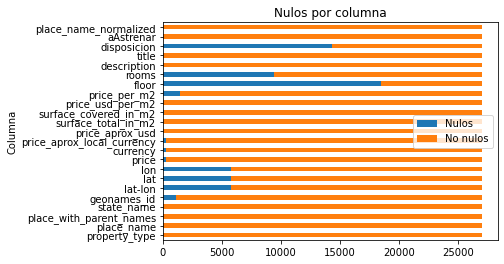

In [216]:
nulls2 = pd.DataFrame({'Columna':data.columns, 'Nulos':data.isnull().sum(),'No nulos':data.notnull().sum()})

# plot a Stacked Bar Chart using matplotlib
nulls2.plot(
  x = 'Columna', 
  kind = 'barh', 
  stacked = True, 
  title = 'Nulos por columna', 
  mark_right = True)

In [217]:
data.rooms.describe()

count   17645.00
mean        2.15
std         1.76
min         0.00
25%         1.00
50%         2.00
75%         3.00
max        22.00
Name: rooms, dtype: float64

In [218]:
data.loc[data.rooms > 10,"property_type"] = "special"

In [219]:
data.loc[data.rooms > 10]

,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,currency,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,description,title,disposicion,aAstrenar,place_name_normalized
876,special,San Nicolás,|Argentina|Capital Federal|San Nicolás|,Capital Federal,6693229.00,"-34.605661,-58.388343",-34.61,-58.39,250000.00,USD,...,382.00,654.45,654.45,1.00,17.00,Corredor Responsable: Mario Gabriel Gerez - CU...,Venta Hotel Familiar en 2 pisos,frente,False,San Nicolás
877,special,Monserrat,|Argentina|Capital Federal|Monserrat|,Capital Federal,3430570.00,"-34.609988,-58.374932",-34.61,-58.37,300000.00,USD,...,472.00,635.59,635.59,1.00,22.00,Corredor Responsable: Mario Gabriel Gerez - CU...,Venta Hotel Familiar Calle Peru al 100,None,False,Monserrat
10592,special,Villa Pueyrredón,|Argentina|Capital Federal|Villa Pueyrredón|,Capital Federal,3429703.00,"-34.5835159,-58.497411",-34.58,-58.50,700000.00,USD,...,400.00,1400.00,1750.00,nan,12.00,Se trata de dos propiedades en una: --> --> en...,"Depto 5amb + Casa 7amb, Cochera Para 6 autos",None,False,Villa Pueyrredón
11721,special,Constitución,|Argentina|Capital Federal|Constitución|,Capital Federal,3435257.00,"-34.6196440159,-58.3783563841",-34.62,-58.38,249000.00,USD,...,200.00,1245.00,1245.00,1.00,12.00,VENTA DE PISO TIPO PH (1º PISO) U$S 249.000 “C...,VENTA PISO TIPO PH - de 200 m2 - Balcón al Frte -,None,False,Constitución
11722,special,San Telmo,|Argentina|Capital Federal|San Telmo|,Capital Federal,3428113.00,"-34.6196545664,-58.3783370836",-34.62,-58.38,249000.00,USD,...,200.00,1245.00,1245.00,1.00,12.00,VENTA DE PISO TIPO PH (1º PISO) U$S 249.000 “C...,PISO DE 200 M2 - Carlos Calvo al 800 - San Tel...,None,False,San Telmo
13044,special,Recoleta,|Argentina|Capital Federal|Recoleta|,Capital Federal,3429595.00,"-34.5921249227,-58.3790816634",-34.59,-58.38,1200000.00,USD,...,363.00,3278.69,3305.79,5.00,12.00,- Excelente piso de 375m en edificio Francés d...,Arroyo y Esmeralda: oficina / vivienda Frances...,frente,False,Recoleta
13065,special,Recoleta,|Argentina|Capital Federal|Recoleta|,Capital Federal,3429595.00,"-34.5924495,-58.3926388",-34.59,-58.39,1280000.00,USD,...,509.00,2392.52,2514.73,6.00,12.00,"Espectacular recepción de sala, doble living y...",Av. Callao - Juncal: Piso de categoría. Cocher...,None,False,Recoleta
13158,special,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,3436077.00,"-34.570631,-58.462415",-34.57,-58.46,2500000.00,USD,...,1015.00,2463.05,2463.05,nan,12.00,Corredor Responsable: Daniel Acosta - CUCICBA ...,Imponente residencia 720 mts2 de terreno y 3 p...,frente,False,Belgrano
13236,special,Almagro,|Argentina|Capital Federal|Almagro|,Capital Federal,3436397.00,"-34.610983,-58.415697",-34.61,-58.42,240000.00,USD,...,180.00,1333.33,1333.33,nan,11.00,Corredor Responsable: Marcelo Trujillo - CUCIC...,Venta PH TODO DESTINO en Almagro,frente,False,Almagro
18180,special,San Telmo,|Argentina|Capital Federal|San Telmo|,Capital Federal,3428113.00,"-34.6196143,-58.3783429",-34.62,-58.38,335000.00,USD,...,320.00,837.50,1046.88,3.00,14.00,Se trata de una propiedad desarrollada todo en...,"14 habitaciones , 5 baños todo en 320mts",frente,False,San Telmo


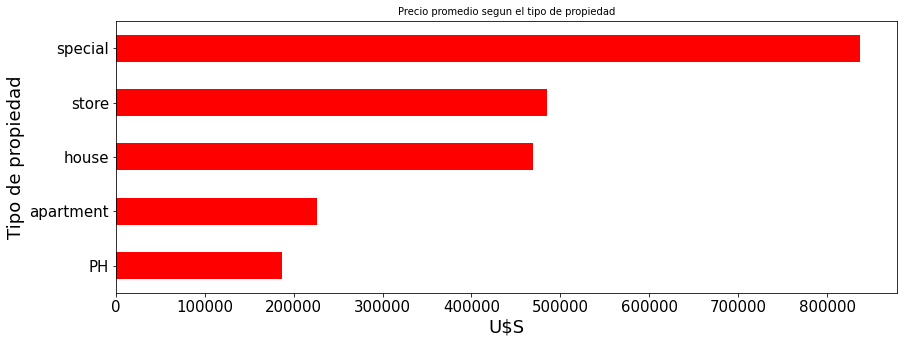

In [220]:
df_tipo_prop = data.groupby('property_type').mean()['price_aprox_usd'].sort_values(ascending=False)[0:5]
graf = df_tipo_prop.sort_values().plot.barh(figsize=(14,5),fontsize=15, color='r')
graf.set_title("Precio promedio segun el tipo de propiedad", fontsize=10)
graf.set_ylabel("Tipo de propiedad", fontsize=18)
graf.set_xlabel("U$S", fontsize=18)
plt.show()

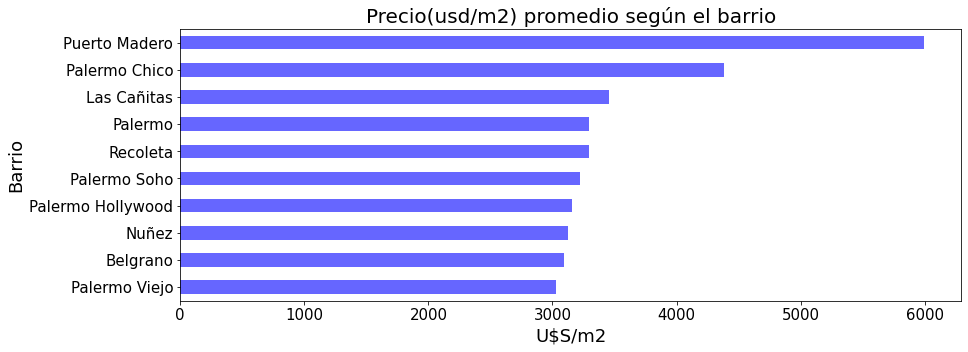

In [221]:
dfzone = data.groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False)[0:10]
g = dfzone.sort_values().plot.barh(figsize=(14,5),color='b',fontsize=15, alpha=0.6);
g.set_title("Precio(usd/m2) promedio según el barrio", fontsize=20)
g.set_ylabel("Barrio", fontsize=18)
g.set_xlabel("U$S/m2", fontsize=18)
plt.show()